 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [1]:
reset -fs

# Loading Modules and Datasets

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import urllib.request
import time
from datetime import datetime
import requests

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [4]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_convert(tz='Europe/Berlin').to_series(keep_tz=True)

# resampling to a time range of 15 minutes and interpolate between the hourly values
df_fin = df_fin.resample('10min', axis='index').interpolate()
df_fin = df_fin.fillna(method='ffill')

# creating columns with name of the day and month
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

In [5]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [6]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_convert(tz='Europe/Berlin').to_series(keep_tz=True)

# resample 
# df_norm = df_norm.resample('H').mean()

In [7]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [8]:
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [9]:
# testing if there are any missing values
print(df_norm[df_norm.isnull().any(axis=1)])
print(df_fin[df_fin.isnull().any(axis=1)])

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm]
Index: []
Empty DataFrame
Columns: [dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, t_pfg30_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pfg30_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name]
Index: []

[0 rows x 28 columns]


# Data Cleaning

In [10]:
# drop rows with NaN, since both datasets don't have the same timeframe
df = df.dropna()
df

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,day_name,month_name
2018-01-01 07:00:00+01:00,0.561235,0.933616,0.372381,0.000000,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,...,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894,Monday,January
2018-01-01 07:10:00+01:00,0.512618,0.958089,0.445471,0.000000,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,...,60.237190,16.589409,9.804977,16.657162,21.955989,2018-01-01 00:00:00+00:00,113.717751,-10.743970,Monday,January
2018-01-01 07:20:00+01:00,0.494356,0.966840,0.472484,0.000000,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,...,61.511338,16.630528,9.837206,16.692246,21.948260,2018-01-01 00:00:00+00:00,115.554543,-9.355046,Monday,January
2018-01-01 07:30:00+01:00,0.484470,0.970603,0.486133,0.000000,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,...,62.785487,16.671646,9.869435,16.727331,21.940530,2018-01-01 00:00:00+00:00,117.391335,-7.966123,Monday,January
2018-01-01 07:40:00+01:00,0.509116,0.983485,0.474370,0.000000,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,...,64.059635,16.712765,9.901665,16.762416,21.932800,2018-01-01 00:00:00+00:00,119.228127,-6.577199,Monday,January
2018-01-01 07:50:00+01:00,0.513224,0.988892,0.475668,0.000000,16.635126,1352.174198,99251.854167,0.533855,0.005022,0.004758,...,65.333783,16.753883,9.933894,16.797500,21.925071,2018-01-01 00:00:00+00:00,121.064919,-5.188276,Monday,January
2018-01-01 08:00:00+01:00,0.443089,0.989338,0.546249,0.000000,16.606744,1352.623506,99259.812500,0.528755,0.005005,0.004739,...,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353,Monday,January
2018-01-01 08:10:00+01:00,0.445928,0.976663,0.530735,0.000000,16.630715,1358.166457,99273.179167,0.527215,0.004983,0.004716,...,67.739224,16.860364,10.003695,16.877704,21.956402,2018-01-01 00:00:00+00:00,124.837074,-2.578109,Monday,January
2018-01-01 08:20:00+01:00,0.438881,0.985819,0.546937,0.000000,16.654685,1363.709408,99286.545833,0.525675,0.004962,0.004693,...,68.870516,16.925726,10.041266,16.922823,21.995463,2018-01-01 00:00:00+00:00,126.772438,-1.356866,Monday,January
2018-01-01 08:30:00+01:00,0.420594,0.975629,0.555035,0.000000,16.678656,1369.252360,99299.912500,0.524135,0.004940,0.004670,...,70.001808,16.991088,10.078838,16.967941,22.034523,2018-01-01 00:00:00+00:00,128.707809,-0.135623,Monday,January


In [11]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

0.1528863870565333
0.7652005515770703
-0.4604089614421554
91.2075218095992
-0.07005703802228408
0.75
Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


In [12]:
# encoding the day of the week as well as the month
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

# Data Exploration

## Correlation matrix and heatmap

In [13]:
# check duplicates
df[df.index.duplicated()]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,...,March,April,May,June,July,August,September,October,November,December


In [14]:
df_corr = pd.DataFrame(df)

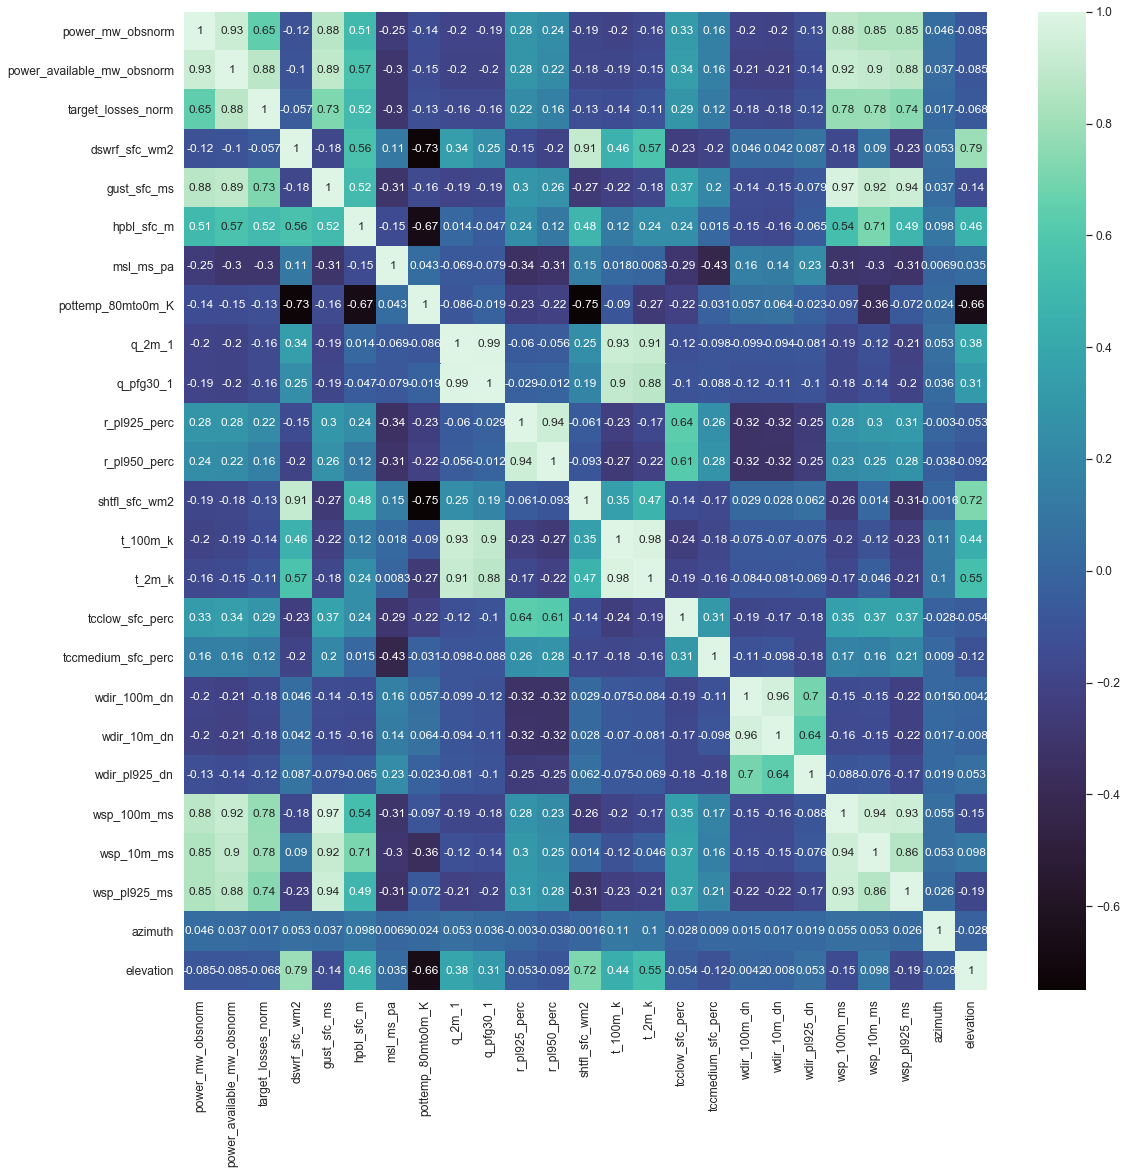

In [15]:
# correalation matrix between each column
plt.figure(figsize=(18,18))
sns.set(font_scale=1.1)
sns.heatmap(df.iloc[:,range(28)].corr(), cmap='mako', annot=True, annot_kws={'size':12})
plt.show()

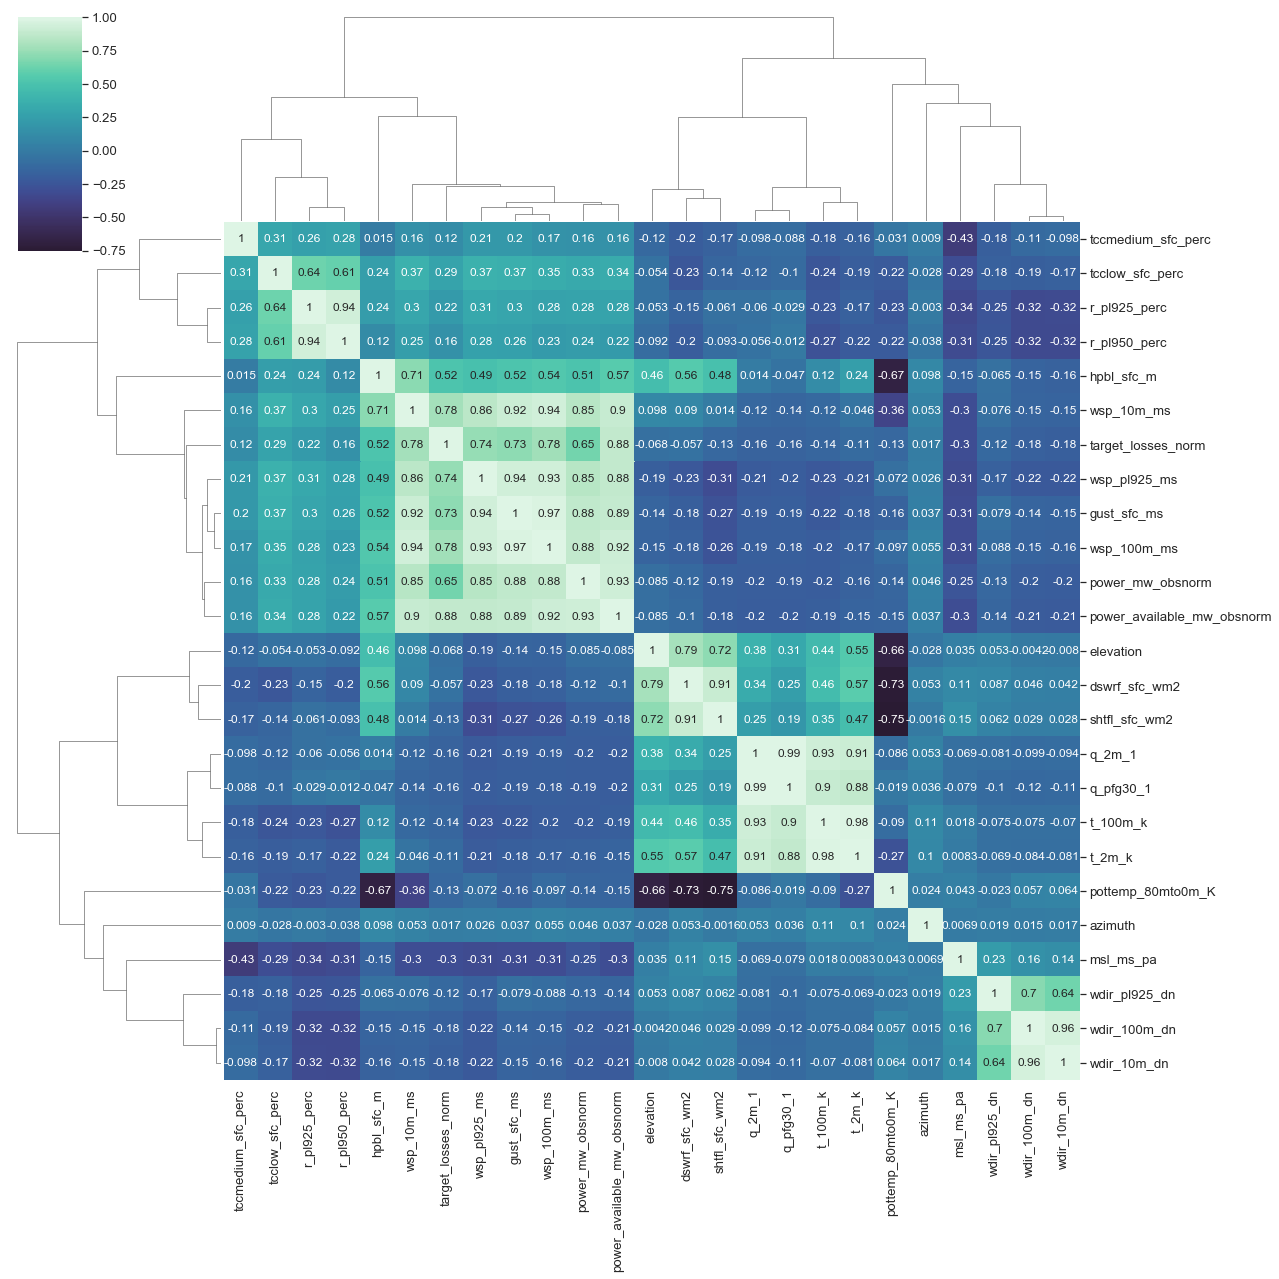

In [16]:
# correlation map as a cluster map
sns.set(font_scale=1.2)
sns.clustermap(df.iloc[:,range(28)].corr(), cmap='mako', center=0.0, annot=True, annot_kws={'size': 12}, figsize=(18,18))
plt.show()

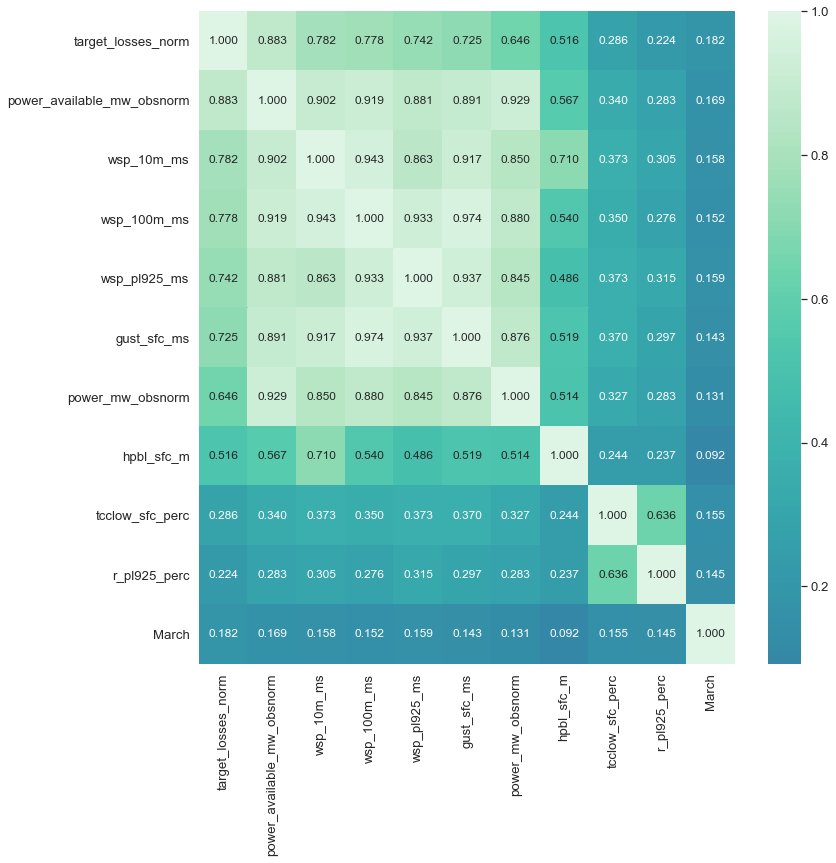

In [17]:

k = 11 #number of variables for heatmap
cols_corr_mat = df.corr().nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

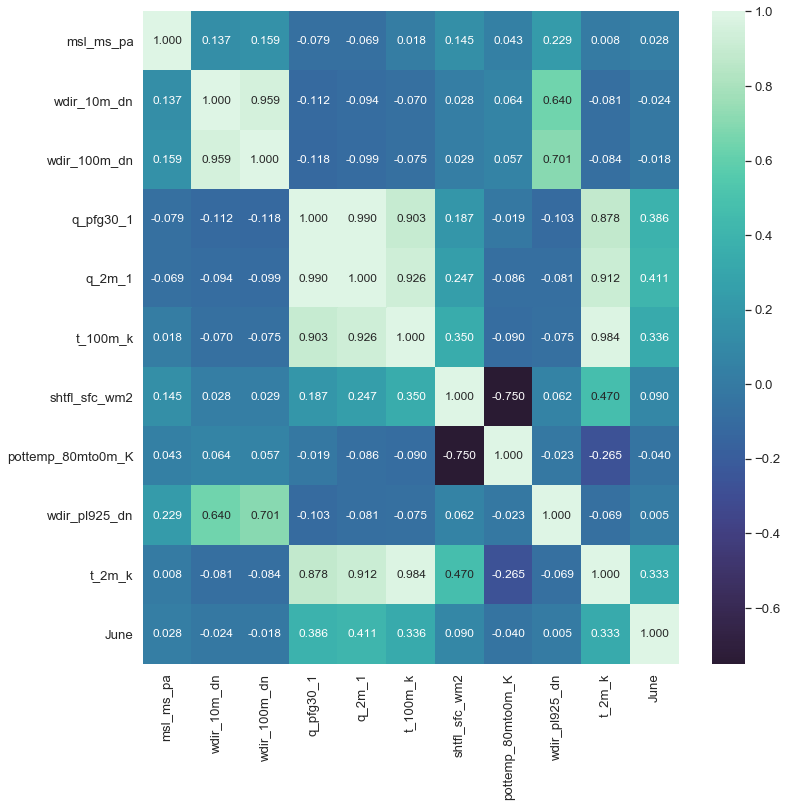

In [18]:

k = 11 #number of variables for heatmap
cols_corr_mat = df.corr().nsmallest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<function matplotlib.pyplot.show(*args, **kw)>

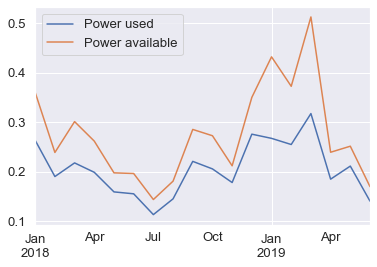

In [21]:
avg_pow = df['power_mw_obsnorm'].resample('M').mean()
avg_pot = df['power_available_mw_obsnorm'].resample('M').mean()
avg_pow.plot(label='Power used')
avg_pot.plot(label='Power available')
plt.legend()
plt.show

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<function matplotlib.pyplot.show(*args, **kw)>

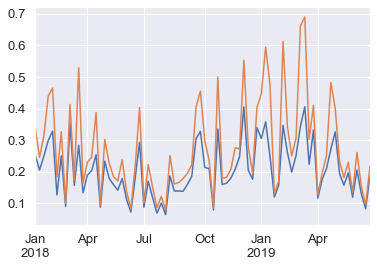

In [24]:
month = ['October'#,'November', 'December'
        ]
for i in month:
    avg_pow = df['power_mw_obsnorm'].resample('W').mean()
    avg_pot = df['power_available_mw_obsnorm'].resample('W').mean()
    avg_pow.plot(label='Power used')
    avg_pot.plot(label='Power available')
plt.show

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.



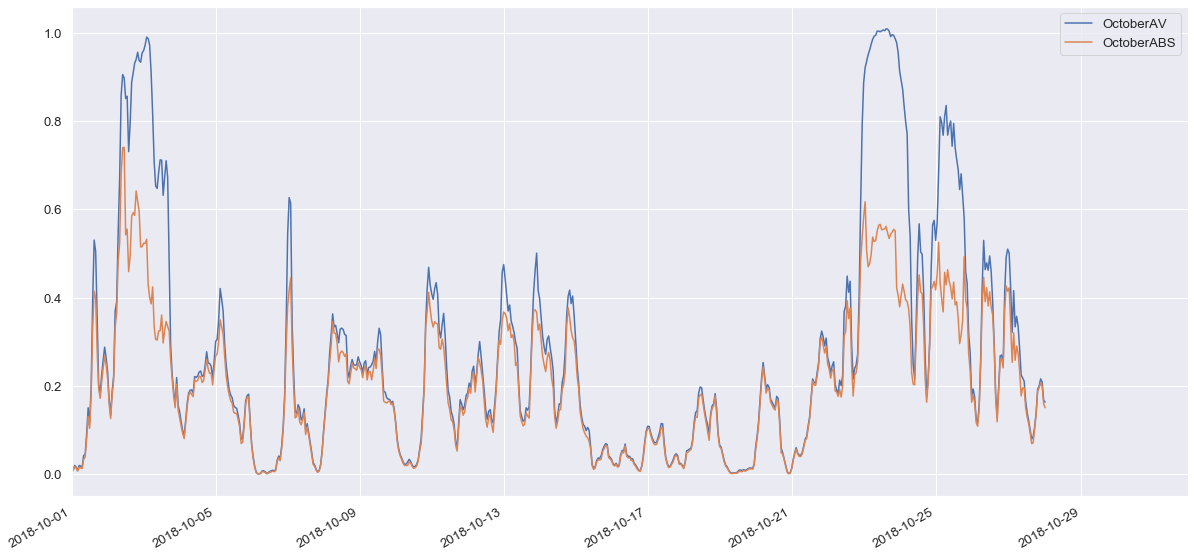

<Figure size 1440x720 with 0 Axes>

In [849]:
#days = ['Monday','Tuesday','Wednesday','Thursday', 'Friday']
month = ['October'#,'November','December'
        ]
for i in month:
    data = df.query('{} == 1'.format(i))
    avg_pow_av = data['power_available_mw_obsnorm'].resample('H').mean()
    avg_pow = data['power_mw_obsnorm'].resample('H').mean()
    avg_pow_av.plot(label=i+'AV',figsize=(20,10))
    avg_pow.plot(label=i+'ABS')
plt.legend()
plt.figure(figsize=(20,10.0))
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future releas

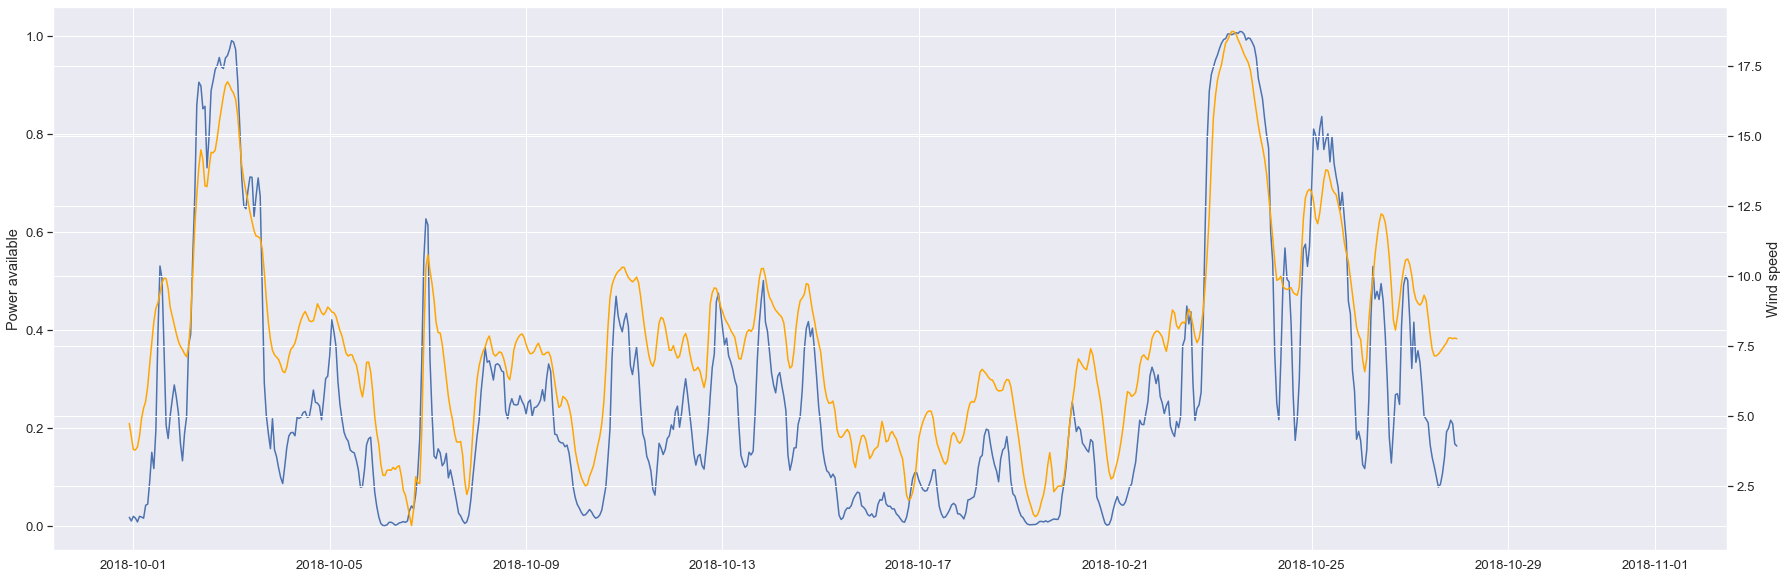

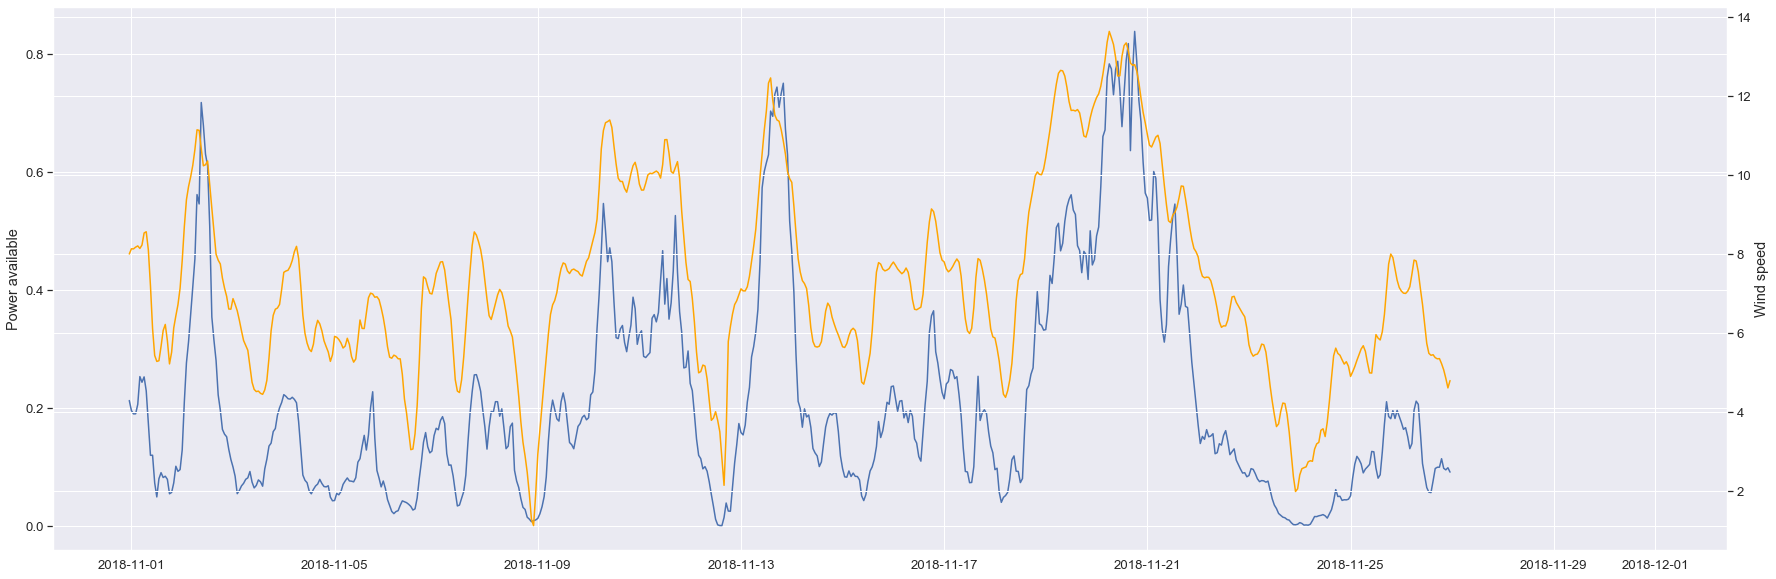

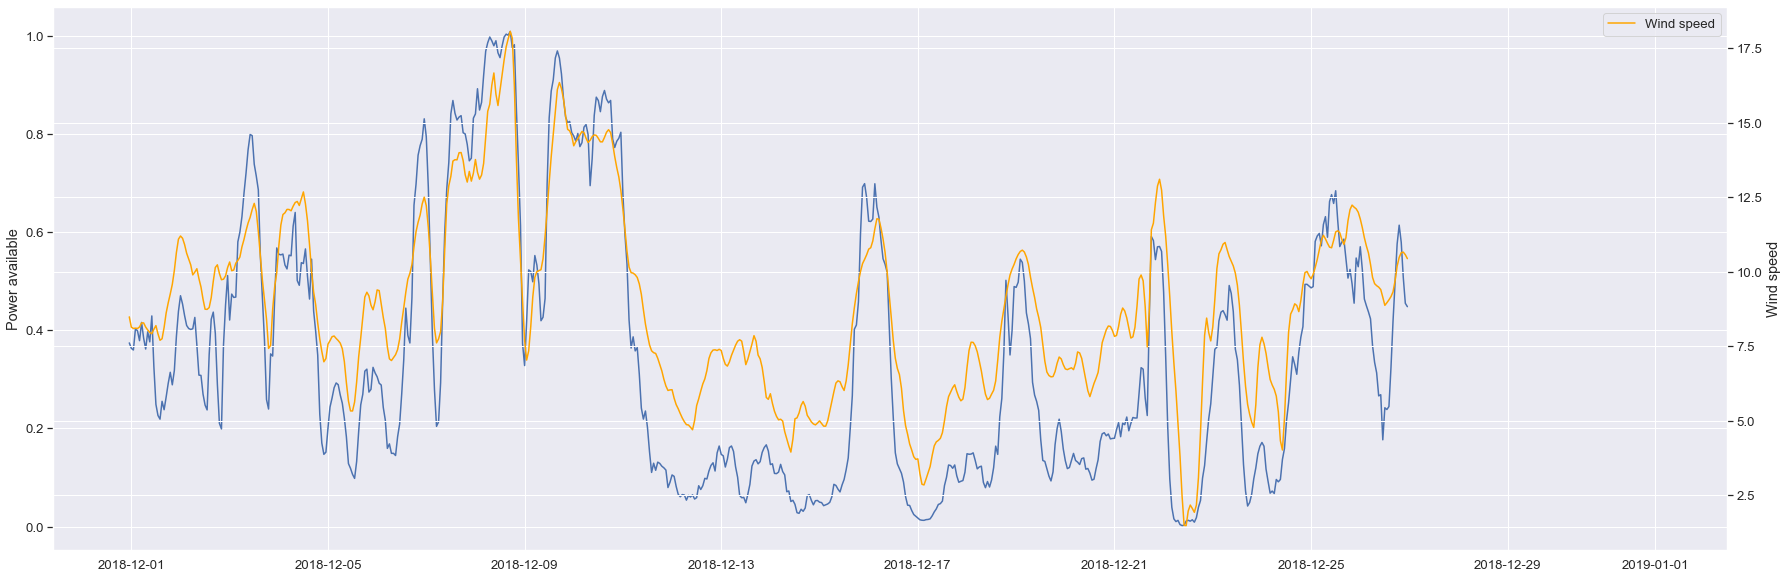

In [25]:
month = ['October','November','December'
        ]
for i in month:
    fig, ax1 = plt.subplots(figsize=(30,10))
    data = df.query('{} == 1'.format(i))
    avail = data['power_available_mw_obsnorm'].resample('H').mean()
    ax1.plot(avail,scalex='autoscale', label='Power Available')
    ax1.set_ylabel('Power available')
    ax2 = ax1.twinx()
    wsp = data['wsp_100m_ms'].resample('H').mean()
    ax2.set_ylabel('Wind speed')
    ax2.plot(wsp,color='orange', label='Wind speed')
plt.legend()
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:407: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/generic.py:415: FutureWarning:

The default of the 'keep_tz' keyword will change to True in a future releas

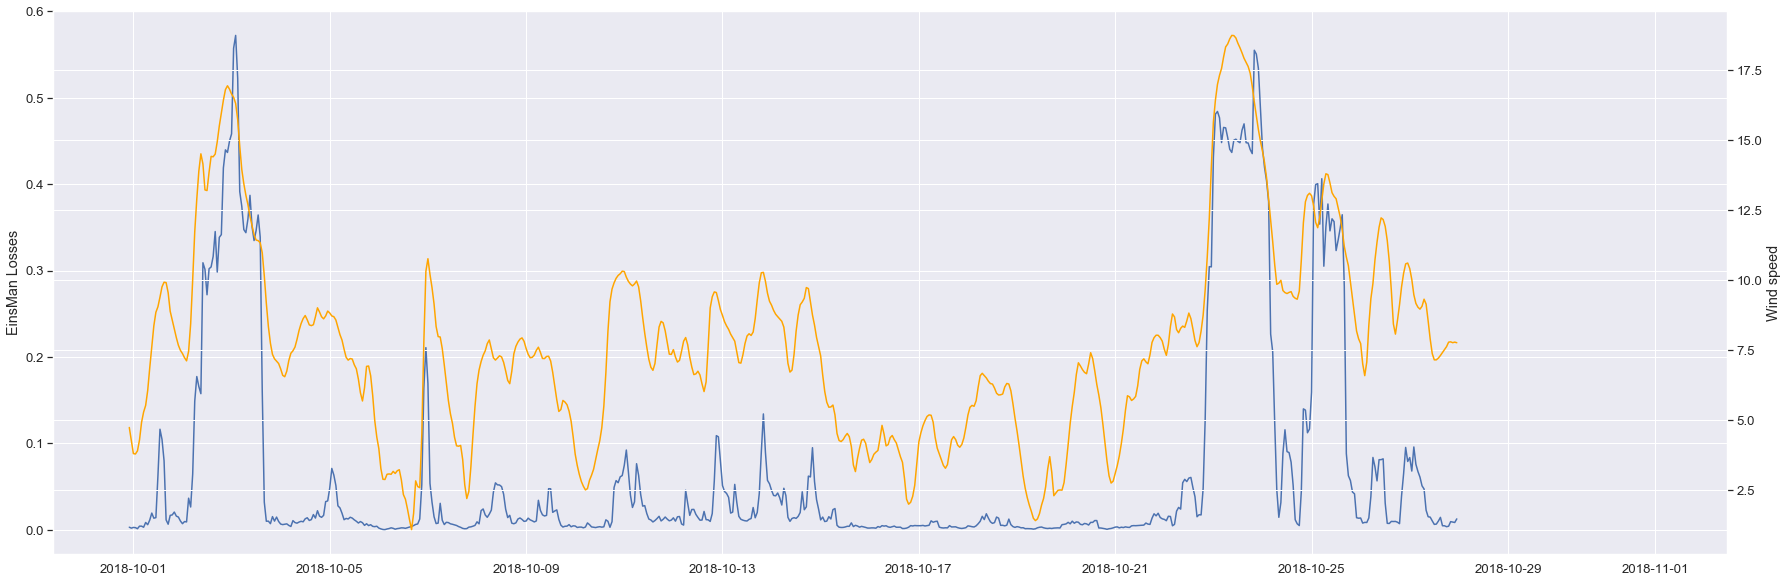

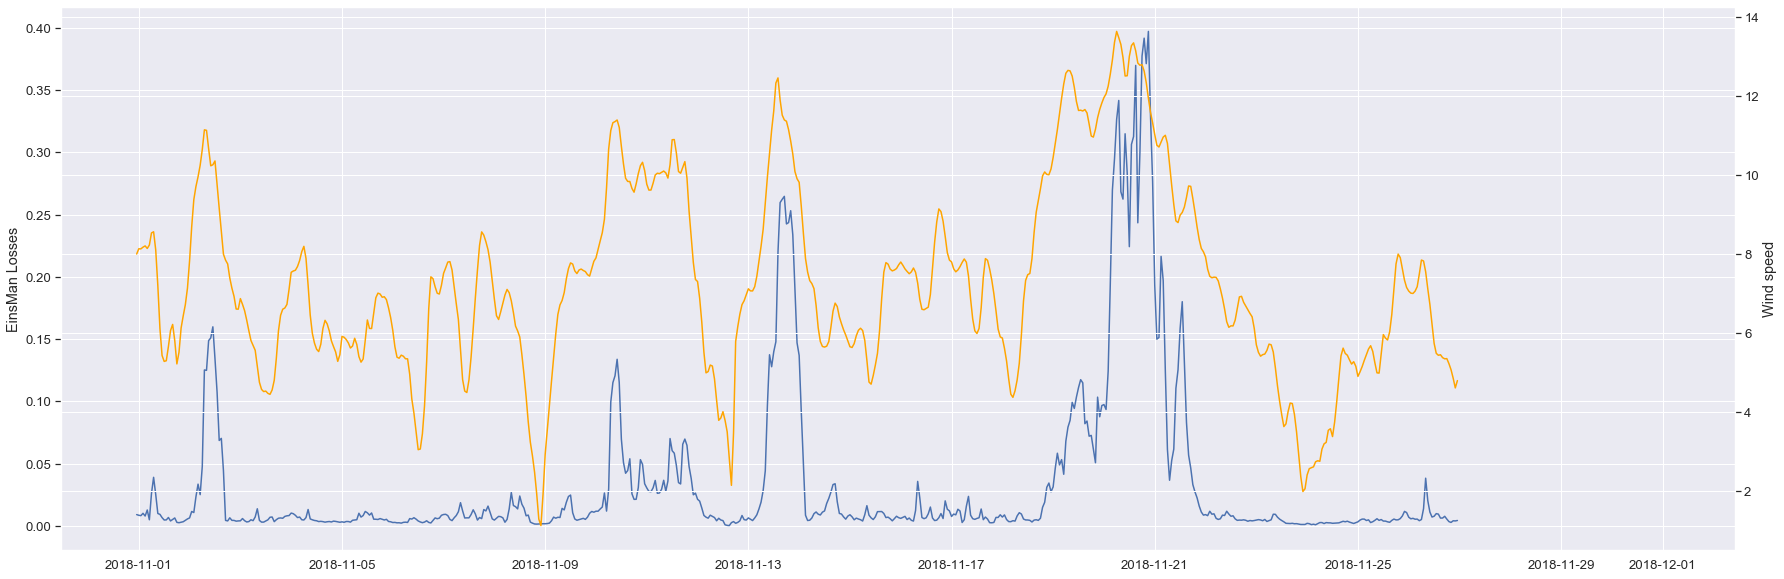

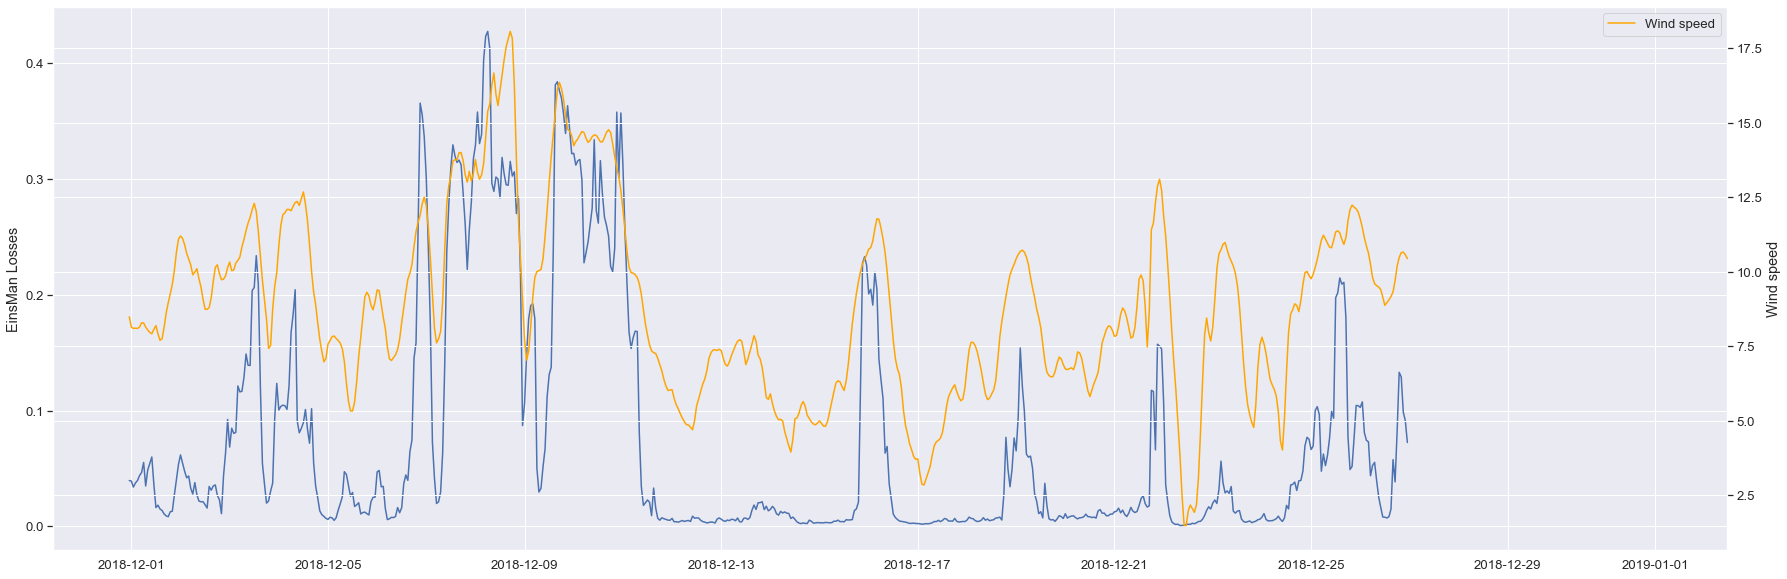

In [26]:
for i in month:
    fig, ax1 = plt.subplots(figsize=(30,10))
    data = df.query('{} == 1'.format(i))
    avail = data['target_losses_norm'].resample('H').mean()
    ax1.plot(avail,scalex='autoscale', label='EinsMan Losses')
    ax1.set_ylabel('EinsMan Losses')
    ax2 = ax1.twinx()
    wsp = data['wsp_100m_ms'].resample('H').mean()
    ax2.set_ylabel('Wind speed')
    ax2.plot(wsp,color='orange', label='Wind speed')
plt.legend()
plt.show()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



<function matplotlib.pyplot.show(*args, **kw)>

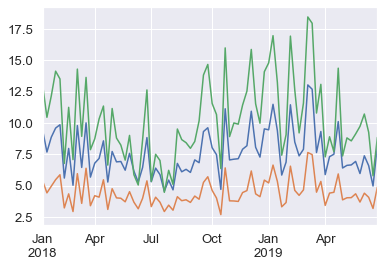

In [27]:
wsp = ['wsp_100m_ms','wsp_10m_ms','wsp_pl925_ms']
for i in wsp:
    avg_wsp = df[i].resample('W').mean()
    avg_wsp.plot()
plt.show

In [28]:
show_dist = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

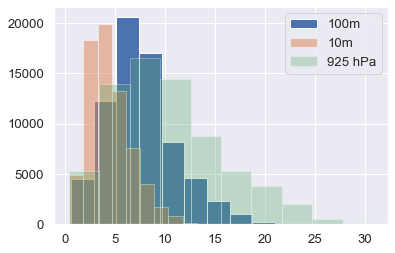

In [29]:
fig, ax = plt.subplots()
rects1 = ax.hist(x=df['wsp_100m_ms'],label='100m')
rects2 = ax.hist(x=df['wsp_10m_ms'],label='10m',alpha=0.5)
rects3 = ax.hist(x=df['wsp_pl925_ms'],label='925 hPa',alpha=0.3)
ax.legend()
plt.show()

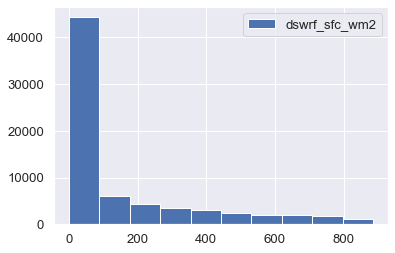

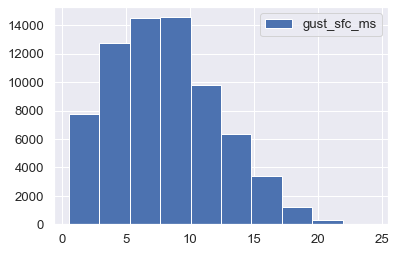

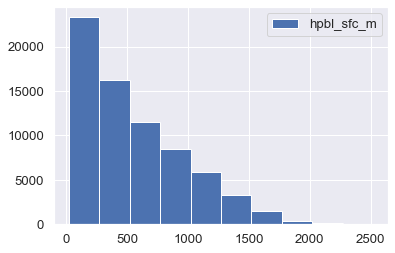

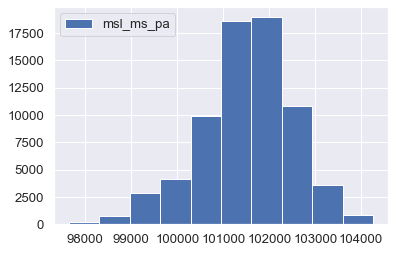

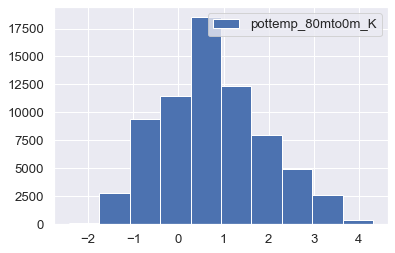

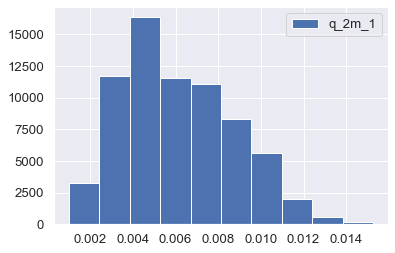

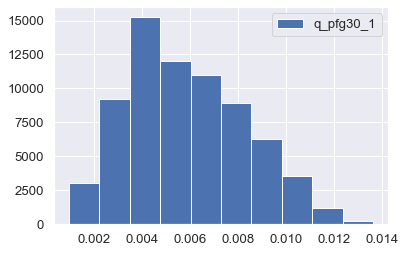

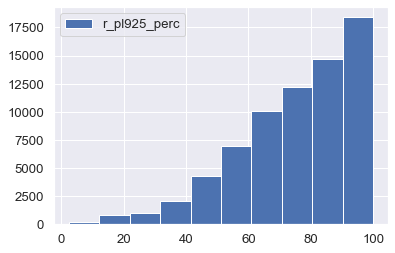

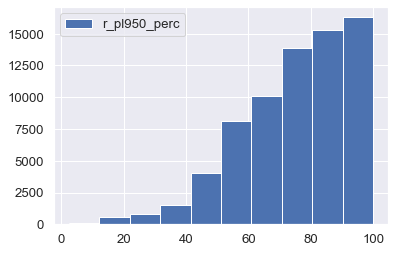

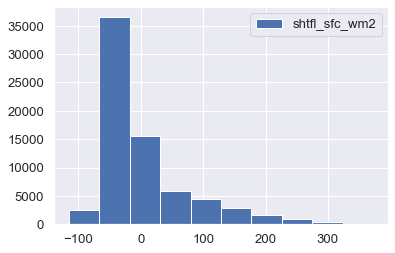

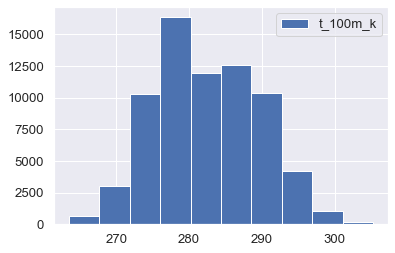

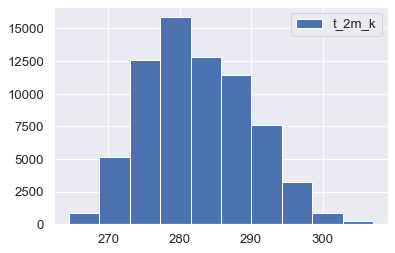

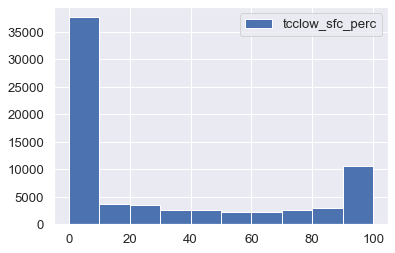

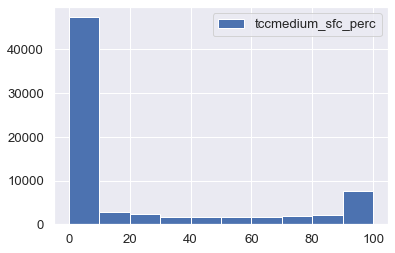

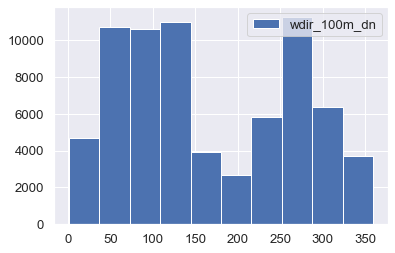

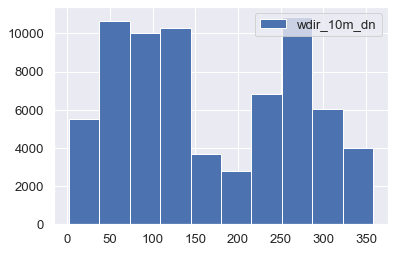

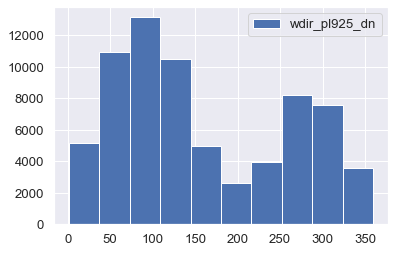

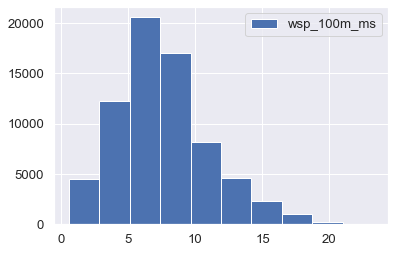

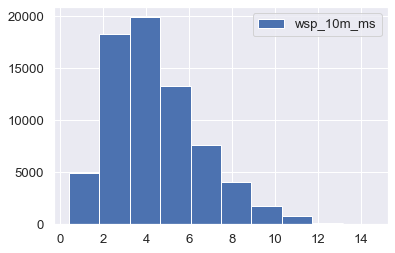

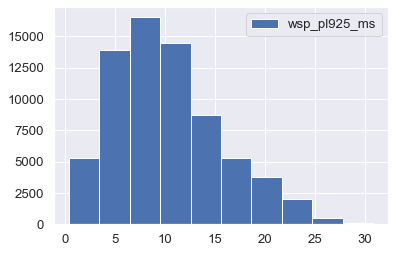

In [30]:
# distribution for each feature in base dataframe
for i in show_dist:
    fig, ax = plt.subplots()
    rects = ax.hist(x=df[i], label=i)
    ax.legend()
    plt.show()

In [31]:
num_features = ['dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa','pottemp_80mto0m_K', 'q_2m_1',
             'q_pfg30_1', 'r_pl925_perc','r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
             'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn','wdir_pl925_dn',
             'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms']

In [32]:
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)